# 3-6. 予測・判断 - サポートベクターマシン（SVM）

サポートベクターマシンとは，データの代表点であるサポートベクタによって予測の識別境界を決定する⼿法で，異なるクラス間の距離（マージン）が最⼤になるように学習を⾏っているモデルである．その中でも，識別境界が直線で表される線形SVMや，カーネル関数を用いて曲線的な分類を可能にしたカーネルSVMなどが存在する．

[メディア芸術データベース・ラボ](https://mediag.bunka.go.jp/madb_lab/)上のサービスを利用して取得したデータを用いて，簡単な分類を行う線形SVMや，カーネルSVMのサンプルコードを見ていこう．

今回は，データベース上からゲームパッケージを取得し，「公開年月日」を特徴量化してプラットフォームがいずれに該当するものなのかを当てる多クラス分類モデルを作っていく．


## データの取得・整形
[メディア芸術データベース・ラボ](https://mediag.bunka.go.jp/madb_lab/)上で提供されている[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)を利用して，ゲームパッケージのデータを取得していく．


以下のコードを[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)上に入力して実行する，または入力を省略した[こちらのURL](https://mediag.bunka.go.jp/madb_lab/lod/sparql/#query=PREFIX%20ma%3A%20%3Chttps%3A%2F%2Fmediaarts-db.bunka.go.jp%2Fdata%2Fproperty%23%3E%0APREFIX%20rdfs%3A%20%20%20%3Chttp%3A%2F%2Fwww.w3.org%2F2000%2F01%2Frdf-schema%23%3E%0APREFIX%20schema%3A%20%3Chttps%3A%2F%2Fschema.org%2F%3E%20SELECT%20%3F%E3%83%A9%E3%83%99%E3%83%AB%20%3F%E7%99%BA%E8%A1%8C%E8%80%85%20%3F%E3%83%97%E3%83%A9%E3%83%83%E3%83%88%E3%83%95%E3%82%A9%E3%83%BC%E3%83%A0%20%3F%E3%83%AC%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5%0AWHERE%20%7B%0A%20%20%3F%E3%82%A2%E3%82%A4%E3%83%86%E3%83%A0%0A%20%20%20%20%20%20%20%20schema%3Agenre%20%22%E3%82%B2%E3%83%BC%E3%83%A0%E3%83%91%E3%83%83%E3%82%B1%E3%83%BC%E3%82%B8%22%3B%0A%20%20%20%20%20%20%20%20schema%3AcontentRating%20%3F%E3%83%AC%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%3B%0A%20%20%20%20%20%20%20%20schema%3AgamePlatform%20%3F%E3%83%97%E3%83%A9%E3%83%83%E3%83%88%E3%83%95%E3%82%A9%E3%83%BC%E3%83%A0%3B%0A%20%20%20%20%20%20%20%20schema%3Apublisher%20%3F%E7%99%BA%E8%A1%8C%E8%80%85%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3F%E3%83%A9%E3%83%99%E3%83%AB%3B%0A%20%20%20%20%20%20%20%20ma%3AdatePublished%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5.%0A%7D&endpoint=https%3A%2F%2Fmediag.bunka.go.jp%2Fsparql&requestMethod=POST&tabTitle=Query&headers=%7B%7D&contentTypeConstruct=application%2Fn-triples%2C*%2F*%3Bq%3D0.9&contentTypeSelect=application%2Fsparql-results%2Bjson%2C*%2F*%3Bq%3D0.9&outputFormat=table)から実行してデータを取得できる．

取得したCSVファイルを「ゲームパッケージ.csv」として保存し，このノートブック上にアップロードしよう．

※「3-4. ディープニューラルネットワーク（DNN）」，「3-4. 学習用データと学習済みモデル」，「3-6. 決定木」，「3-7. 形態素解析」，「3-7. かな漢字変換」，「3-7. 表現学習」と同じデータセットを作成するため，もし同じものを持っている場合は以下の取得作業は不要なので，そちらをアップロードしよう．

```
PREFIX ma: <https://mediaarts-db.bunka.go.jp/data/property#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/> SELECT ?ラベル ?発行者 ?プラットフォーム ?レーティング ?公開年月日
WHERE {
  ?アイテム
        schema:genre "ゲームパッケージ";
        schema:contentRating ?レーティング;
        schema:gamePlatform ?プラットフォーム;
        schema:publisher ?発行者;
        rdfs:label ?ラベル;
        ma:datePublished ?公開年月日.
}
```

取得したデータセットを，Python上で扱いやすい形にしていく．
pandasというライブラリを用いて，csv形式のファイルの中身をDataFrameという型に変換し，扱っていく．

In [1]:
# 必要なモジュールの読み込み
!pip install japanize-matplotlib

import numpy as np
import pandas as pd
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=fee14390c6d942d1e12d1ebf07de575c340f75be36804af7b4463597ae728cd4
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
games = pd.read_csv("/content/ゲームパッケージ.csv")
games = games.drop_duplicates()
games = games.reset_index(drop=True)
games

ラベル  \
0                           Dance Dance Revolution GB2   
1                                     プロ野球 ファミスタ リターンズ   
2                                      プロ野球 ファミスタ 2011   
3                                              フロッガー3D   
4                                           ブレイブリーセカンド   
...                                                ...   
21976                 バイオショック インフィニット PlayStation Now版   
21977  バイオハザード リベレーションズ アンベールド エディション PlayStation Now版   
21978                           巫剣神威控 PlayStation Now版   
21979                 ネバーエンディング ナイトメア PlayStation Now版   
21980                   雷電IV OverKill PlayStation Now版   

                           発行者       プラットフォーム            レーティング       公開年月日  
0                      コナミ株式会社         ゲームボーイ  CERO D (17才以上対象)  2000-11-16  
1        株式会社バンダイナムコエンターテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2015-10-08  
2              株式会社バンダイナムコゲームス      ニンテンドー3DS    CERO A (全年齢対象)  2011-03-31  
3         株式会社コナミデジタルエンタテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2011-09-22  
4              株式会社スクウェア・エニックス      ニンテンドー3DS  CERO C (15才以上対象)  2015-04-23  
...                        ...            ...               ...         ...  
21976  テイクツー・インタラクティブ・ジャパン合同会社  プレイステーション Now  CERO D (17才以上対象)  2017-09-19  
21977                 株式会社カプコン  プレイステーション Now  CERO D (17才以上対象)  2016-09-20  
21978           アクティブゲーミングメディア  プレイステーション Now  CERO C (15才以上対象)  2017-07-20  
21979           アクティブゲーミングメディア  プレイステーション Now  CERO D (17才以上対象)  2017-07-20  
21980                       モス  プレイステーション Now    CERO A (全年齢対象)  2017-02-21  

[21981 rows x 5 columns]

## データクレンジング
想定外の値を持つデータを除外する作業をする．
例えば，`games`の["公開年月日"]列には`yyyy-mm-dd`の形式で日付が入っていることが期待されるが，そうでない形式のものが含まれている可能性もある．
実際に見てみよう．

In [3]:
for day in games['公開年月日']:
  if len(day) < 10:
    print(day)

2007
2000
2009
2002
2006
2006
2006
2001
2014
2002
1999
1998
2007
2003
2008
2001
2003
2013
2017
2001
2002
2001
2005
1998
1998
2006


こういったものを先に除外しておくと，後の計算が楽に正しく行えるようになる．


In [4]:
games = games[games['公開年月日'].str.len() >= 10]
games = games.reset_index(drop=True)
games

ラベル  \
0                           Dance Dance Revolution GB2   
1                                     プロ野球 ファミスタ リターンズ   
2                                      プロ野球 ファミスタ 2011   
3                                              フロッガー3D   
4                                           ブレイブリーセカンド   
...                                                ...   
21950                 バイオショック インフィニット PlayStation Now版   
21951  バイオハザード リベレーションズ アンベールド エディション PlayStation Now版   
21952                           巫剣神威控 PlayStation Now版   
21953                 ネバーエンディング ナイトメア PlayStation Now版   
21954                   雷電IV OverKill PlayStation Now版   

                           発行者       プラットフォーム            レーティング       公開年月日  
0                      コナミ株式会社         ゲームボーイ  CERO D (17才以上対象)  2000-11-16  
1        株式会社バンダイナムコエンターテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2015-10-08  
2              株式会社バンダイナムコゲームス      ニンテンドー3DS    CERO A (全年齢対象)  2011-03-31  
3         株式会社コナミデジタルエンタテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2011-09-22  
4              株式会社スクウェア・エニックス      ニンテンドー3DS  CERO C (15才以上対象)  2015-04-23  
...                        ...            ...               ...         ...  
21950  テイクツー・インタラクティブ・ジャパン合同会社  プレイステーション Now  CERO D (17才以上対象)  2017-09-19  
21951                 株式会社カプコン  プレイステーション Now  CERO D (17才以上対象)  2016-09-20  
21952           アクティブゲーミングメディア  プレイステーション Now  CERO C (15才以上対象)  2017-07-20  
21953           アクティブゲーミングメディア  プレイステーション Now  CERO D (17才以上対象)  2017-07-20  
21954                       モス  プレイステーション Now    CERO A (全年齢対象)  2017-02-21  

[21955 rows x 5 columns]

また，取得したデータのうち目標クラスとなるゲームプラットフォームはどれくらいの種類があって，それぞれどれくらいの要素数を持つのか確認してみよう．

In [5]:
count = collections.Counter(games["プラットフォーム"])
count

Counter({'ゲームボーイ': 1,
         'ニンテンドー3DS': 1993,
         'Xbox One': 645,
         'プレイステーション4': 1712,
         'プレイステーション・ポータブル': 3101,
         'Xbox 360': 738,
         'プレイステーション Vita': 1979,
         'プレイステーション3': 2307,
         'ドリームキャスト': 326,
         'セガサターン': 397,
         'Wii U': 817,
         'メガドライブ': 2,
         'ゲームボーイアドバンス': 233,
         'Wii': 998,
         'ニンテンドーDS': 2050,
         'ゲームアーカイブス': 945,
         'プレイステーション': 12,
         'プレイステーション2': 2707,
         'PCエンジン': 2,
         'Nintendo Switch': 315,
         'Microsoft Windows': 223,
         'macOS': 13,
         'ワンダースワン': 1,
         'ゲームギア': 5,
         'Xbox': 78,
         'ニンテンドーゲームキューブ': 128,
         '3DO': 54,
         'PC-FX': 3,
         'プレイステーション Now': 170})

今回は発売年月日のみによってある程度分類がうまくいくように，任天堂の家庭用ゲーム機のうち、据え置型のプラットフォーム（据置機）のみに絞ることとする．

In [6]:
new_classes = ["ニンテンドーゲームキューブ", "Wii", "Wii U", "Nintendo Switch"]
games = games[games['プラットフォーム'].isin(new_classes)]
collections.Counter(games["プラットフォーム"])



Counter({'Wii U': 817,
         'Wii': 998,
         'Nintendo Switch': 315,
         'ニンテンドーゲームキューブ': 128})

## データのベクトル化
データは揃ったが，このままタイトルや発行者などの文字列をモデルに直接入力することはできない．

そこで，今回特徴量にする情報群を，深層学習の章で用いたのと同じようにベクトル化していく．
（本来決定木ではカテゴリ変数をそのまま特徴量としてもいいのだが，性能比較の意味も込めて同じOne-hotベクトルによるエンコーディングで学習を行うこととする）

### 目標変数（クラス）のベクトル化
各ゲームプラットフォームをカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [7]:
# ワンホットベクトルへのエンコードを行うインスタンスlabel_encoderの作成
label_encoder = LabelEncoder()

# プラットフォームが何か？を表すワンホットベクトルへの学習・変換を同時に行う関数．変換後はyに格納
y = label_encoder.fit_transform(np.array(games['プラットフォーム']).reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 説明変数のベクトル化

公開年月日を，公開年/月/日というふうに３つのベクトルに分けて表現することにする．

In [8]:
years = []
months = []
dates = []
for day in games['公開年月日']:
  y_m_d = day.split("-")
  years.append(int(y_m_d[0]))
  months.append(int(y_m_d[1]))
  dates.append(int(y_m_d[2]))

years = np.array(years).reshape(-1,1)
months = np.array(months).reshape(-1,1)
dates = np.array(dates).reshape(-1,1)

# 各特徴量を横並びに結合して，1つのゲームパッケージにつき1つの結合された特徴量ベクトルが対応するようにする
X = np.concatenate([years, months, dates], axis=1)
X.shape

(2258, 3)

3次元の特徴量を持つデータが11120件作成された．

### データの次元削減
この後で可視化のプロセスを行いたいので，PCA（主成分分析）を利用して特徴量次元を2次元に削減する．

In [9]:
# 正規化
X = StandardScaler().fit_transform(X)

model_pca = PCA(n_components=2)
X = model_pca.fit_transform(X)

print(f"PCA1の寄与率: {model_pca.explained_variance_ratio_[0]}, PCA2の寄与率: {model_pca.explained_variance_ratio_[1]}")

PCA1の寄与率: 0.37726529229711236, PCA2の寄与率: 0.3255300556663163



### 学習データとテストデータに分ける

In [10]:
# デフォルトでは学習データは75%，テストデータは25%になる
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), shuffle=True)

## 線形SVM

実際に分類を行ってみて，それを可視化しよう．

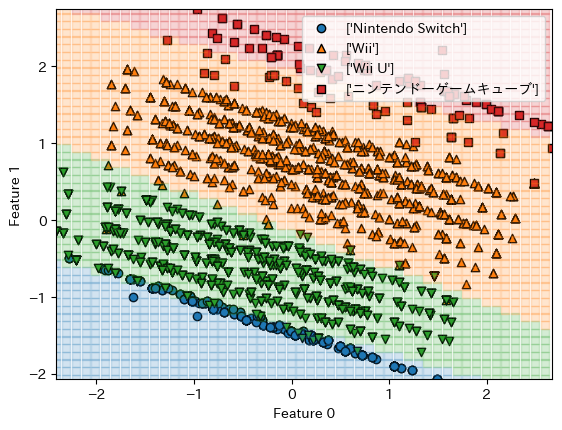

In [11]:
#モデルの作成・学習
lin_svm = LinearSVC().fit(X_train, y_train)

# 決定関数のy切片と傾き
b = lin_svm.intercept_
w = lin_svm.coef_

# 予測値
y_pred = lin_svm.predict(X_test)

# グラフの軸の範囲の設定
f0_min, f0_max = min(np.transpose(X)[0]), max(np.transpose(X)[0])
f1_min, f1_max = min(np.transpose(X)[1]), max(np.transpose(X)[1])

# グラフの点の種類，線の種類を指定
markers = ['o', '^', 'v', 's']
line_styles = ['-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# プロット
fig, ax = plt.subplots()

for cls, marker, linestyle, color in zip(range(len(new_classes)), markers, line_styles, colors):
  #点のプロット
  x = X[y==cls]
  ax.scatter(x[:, 0], x[:, 1], c=[color], ec='k', marker=marker, label=label_encoder.inverse_transform([cls]))


# 背景のプロット
for f0 in np.arange(f0_min, f0_max, 0.1):
  for f1 in np.arange(f1_min, f1_max, 0.1):
      conf = [b[cls] + w[cls, 0] * f0 + w[cls, 1] * f1 for cls in range(len(new_classes))]
      ax.scatter(f0, f1, c=colors[np.argmax(conf)], marker='s', s=40, alpha=0.2)

ax.set_xlim(f0_min, f0_max)
ax.set_ylim(f1_min, f1_max)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.legend()

plt.show()

上のグラフでは，背景の色の差で描かれる境界が「各クラスの決定関数の値を比べた時，最も値が大きいクラスが変わる部分」になる．

同じ発行者の同じ据置機のみが対象になっているということで，販売年月日からのみでも線形SVMでかなり綺麗にわけることができている．

## カーネルSVM
カーネルSVMを利用して同様の分類問題に挑戦してみよう．
カーネルSVMではscikit-learnのSVCの引数kernelにさまざまな値を渡すことでさまざまなカーネル関数によるカーネルSVMを簡単に構築できる．
今回はRBFカーネルを利用してみよう．

In [12]:
from sklearn.svm import SVC

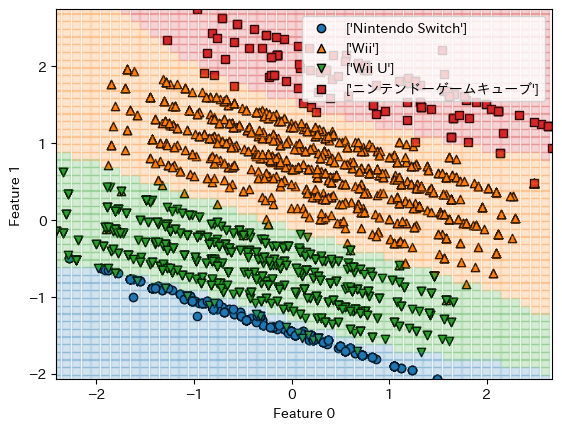

In [13]:
#モデルの作成・学習
rbf_svm = SVC(kernel='rbf').fit(X_train, y_train)

# 予測値
y_pred = rbf_svm.predict(X_test)

# グラフの軸の範囲の設定
f0_min, f0_max = min(np.transpose(X)[0]), max(np.transpose(X)[0])
f1_min, f1_max = min(np.transpose(X)[1]), max(np.transpose(X)[1])

# グラフの点の種類，線の種類を指定
markers = ['o', '^', 'v', 's']
line_styles = ['-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# プロット
fig, ax = plt.subplots()

for cls, marker, linestyle, color in zip(range(len(new_classes)), markers, line_styles, colors):
  #点のプロット
  x = X[y==cls]
  ax.scatter(x[:, 0], x[:, 1], c=[color], ec='k', marker=marker, label=label_encoder.inverse_transform([cls]))

# 背景のプロット
for f0 in np.arange(f0_min, f0_max, 0.1):
  for f1 in np.arange(f1_min, f1_max, 0.1):
      conf = rbf_svm.decision_function([[f0, f1]])
      ax.scatter(f0, f1, c=colors[np.argmax(conf)], marker='s', s=40, alpha=0.2)

ax.set_xlim(f0_min, f0_max)
ax.set_ylim(f1_min, f1_max)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.legend()

plt.show()

線形SVMと比べて，やや曲線的な境界になっていることがわかる．